In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
# setting a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
emotion_labels = {0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Sad'}

train_data_path = "C:\\Users\\syedn\\Melodex\\Melodex-Recommendation-System\\venv\\FER_dataset\\train"
test_data_path = "C:\\Users\\syedn\\Melodex\\Melodex-Recommendation-System\\venv\\FER_dataset\\test"

In [23]:
def initialise_FER_model(inp_shape=(48, 48, 1), num_classes=4):
    
    model = Sequential([
        Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=inp_shape),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),
        
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),
        
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),  
        
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [ ]:
def train_FER_model():
    
    # only the subdirectories of the emotions specified below
    allowed_emotions = ['angry', 'fear', 'happy', 'sad']
    
    # data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range=0.1
    )
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
        train_data_path,
        target_size=(48, 48),
        color_mode='grayscale',
        batch_size=64,
        classes=allowed_emotions,  # only the allowed classes 
        class_mode='categorical',
        shuffle=True
    )
    
    validation_generator = test_datagen.flow_from_directory(
        test_data_path,
        target_size=(48, 48),
        color_mode='grayscale',
        batch_size=64,
        classes=allowed_emotions,  # specified the same as train gen
        class_mode='categorical',
        shuffle=False
    )

    class_mapping = {
        train_generator.class_indices[emotion]: emotion_labels[idx]
        for idx, emotion in enumerate(allowed_emotions)
    }
    
    model = initialise_FER_model(num_classes=len(allowed_emotions))
    model.summary()
    
    checkpoint = ModelCheckpoint(
        'best_model_4emotions.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )
    
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=8,
        verbose=1
    )
    
    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        callbacks=[checkpoint, reduce_lr, early_stopping]
    )
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    validation_loss, validation_accuracy = model.evaluate(validation_generator)
    print(f"Validation accuracy: {validation_accuracy:.4f}")
    
    # save the model
    model.save('facial_expression_model_4emotions.keras')
    
    return model


Found 16911 images belonging to 4 classes.
Found 5002 images belonging to 4 classes.


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,871,044 (22.40 MB)

 Trainable params: 5,868,228 (22.39 MB)

 Non-trainable params: 2,816 (11.00 KB)

Epoch 1/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3504 - loss: 1.8466
Epoch 1: val_accuracy improved from -inf to 0.27549, saving model to best_model_4emotions.keras
265/265 ━━━━━━━━━━━━━━━━━━━━ 562s 2s/step - accuracy: 0.3505 - loss: 1.8458 - val_accuracy: 0.2755 - val_loss: 2.1164 - learning_rate: 0.0010
Epoch 2/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4175 - loss: 1.3879
Epoch 2: val_accuracy improved from 0.27549 to 0.43922, saving model to best_model_4emotions.keras
265/265 ━━━━━━━━━━━━━━━━━━━━ 448s 2s/step - accuracy: 0.4176 - loss: 1.3876 - val_accuracy: 0.4392 - val_loss: 1.2374 - learning_rate: 0.0010
Epoch 3/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5203 - loss: 1.1225
Epoch 3: val_accuracy improved from 0.43922 to 0.51359, saving model to best_model_4emotions.keras
265/265 ━━━━━━━━━━━━━━━━━━━━ 465s 2s/step - accuracy: 0.5203 - loss: 1.1223 - val_accuracy: 0.5136 - val_loss: 1.0928 - learning_rate: 0.0010
Epoch 4/10
265/265 ━━━━━━

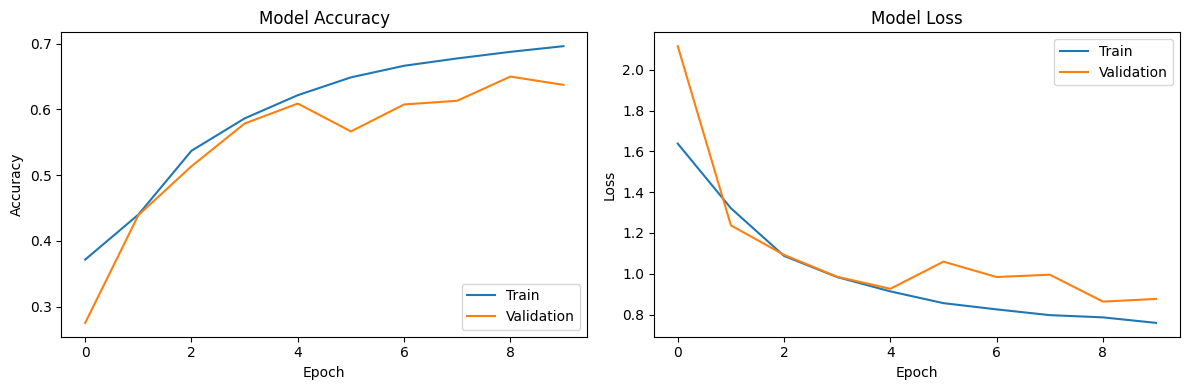

79/79 ━━━━━━━━━━━━━━━━━━━━ 24s 309ms/step - accuracy: 0.5079 - loss: 1.1009
Validation accuracy: 0.6373


<Sequential name=sequential_4, built=True>

In [31]:
train_FER_model()

In [ ]:
def continue_training(model_path, epochs=20, output_model_path='C:\\Users\\syedn\\Melodex\\Melodex-Recommendation-System\\venv\\Models\\facial_expression_model_4emotions_continued.keras'):
    # Load the saved model
    model = load_model(model_path)
    
    # Modify the allowed subdirectories
    allowed_emotions = ['angry', 'fear', 'happy', 'sad']
    
    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range=0.1
    )
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    # print("Loading training data...")
    train_generator = train_datagen.flow_from_directory(
        train_data_path,
        target_size=(48, 48),
        color_mode='grayscale',
        batch_size=64,
        classes=allowed_emotions,  # Explicitly specify allowed classes
        class_mode='categorical',
        shuffle=True
    )
    
    # print("Loading validation data...")
    validation_generator = test_datagen.flow_from_directory(
        test_data_path,
        target_size=(48, 48),
        color_mode='grayscale',
        batch_size=64,
        classes=allowed_emotions,  # Explicitly specify allowed classes
        class_mode='categorical',
        shuffle=False
    )
    
    # Callbacks
    checkpoint = ModelCheckpoint(
        'best_continued_4emotions_model2.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.000001,
        verbose=1
    )
    
    # Continue training
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=[checkpoint, reduce_lr]
    )
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()
    
    # Save the final model with a different name
    model.save(output_model_path)
    
    return model, history

# Usage:
# continued_model, continued_history = continue_training('best_model.keras', epochs=30)

Found 16911 images belonging to 4 classes.
Found 5002 images belonging to 4 classes.
Epoch 1/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7050 - loss: 0.7365
Epoch 1: val_accuracy improved from -inf to 0.64814, saving model to best_continued_4emotions_model.keras
265/265 ━━━━━━━━━━━━━━━━━━━━ 416s 2s/step - accuracy: 0.7050 - loss: 0.7365 - val_accuracy: 0.6481 - val_loss: 0.8601 - learning_rate: 0.0010
Epoch 2/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7153 - loss: 0.7194
Epoch 2: val_accuracy did not improve from 0.64814
265/265 ━━━━━━━━━━━━━━━━━━━━ 373s 1s/step - accuracy: 0.7153 - loss: 0.7194 - val_accuracy: 0.6365 - val_loss: 0.8717 - learning_rate: 0.0010
Epoch 3/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7063 - loss: 0.7245
Epoch 3: val_accuracy did not improve from 0.64814
265/265 ━━━━━━━━━━━━━━━━━━━━ 374s 1s/step - accuracy: 0.7064 - loss: 0.7245 - val_accuracy: 0.6403 - val_loss: 0.8812 - learning_rate: 0.0010
Epoch 4/20
265/265 ━━━━━━━

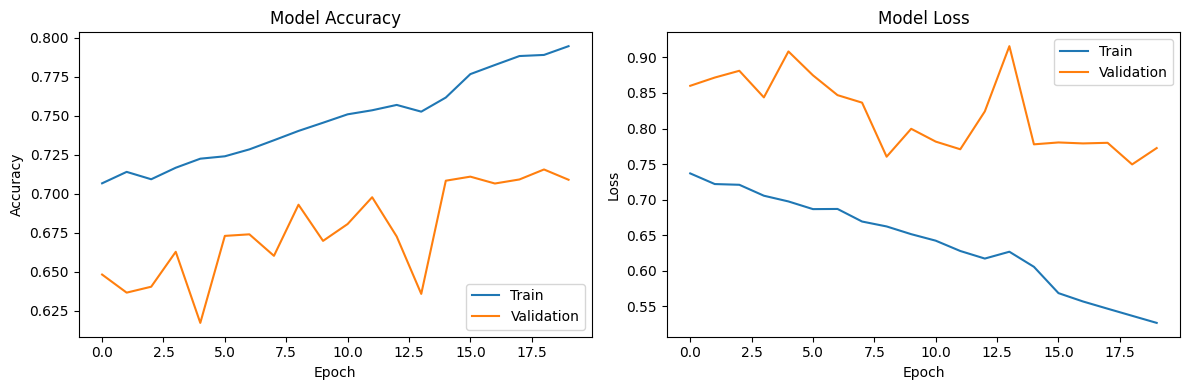

In [37]:
continued_model, continued_history = continue_training('facial_expression_model_4emotions.keras', epochs=20)

Found 16911 images belonging to 4 classes.
Found 5002 images belonging to 4 classes.
Epoch 1/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7923 - loss: 0.5284
Epoch 1: val_accuracy improved from -inf to 0.70872, saving model to best_continued_4emotions_model2.keras
265/265 ━━━━━━━━━━━━━━━━━━━━ 367s 1s/step - accuracy: 0.7923 - loss: 0.5283 - val_accuracy: 0.7087 - val_loss: 0.7959 - learning_rate: 2.0000e-04
Epoch 2/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7968 - loss: 0.5133
Epoch 2: val_accuracy improved from 0.70872 to 0.71771, saving model to best_continued_4emotions_model2.keras
265/265 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.7968 - loss: 0.5133 - val_accuracy: 0.7177 - val_loss: 0.7543 - learning_rate: 2.0000e-04
Epoch 3/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8014 - loss: 0.5166
Epoch 3: val_accuracy improved from 0.71771 to 0.71971, saving model to best_continued_4emotions_model2.keras
265/265 ━━━━━━━━━━━━━━━━━━━━ 363s 1s/step

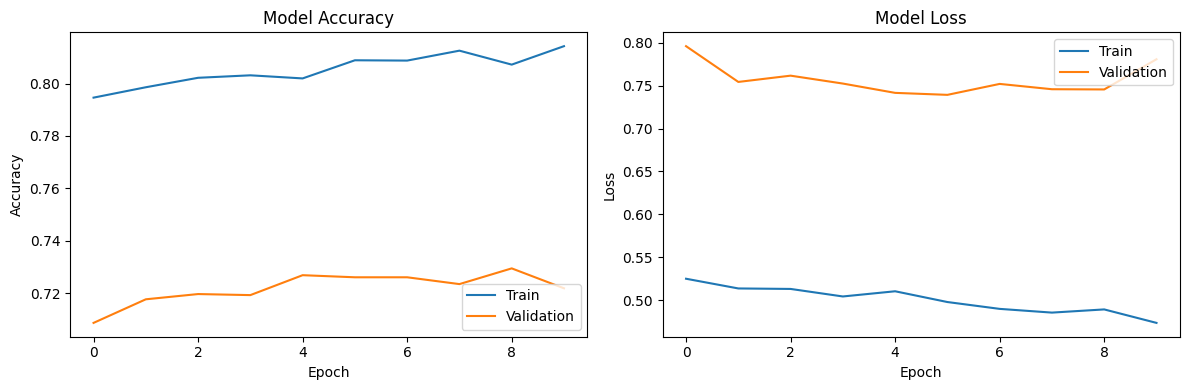

In [41]:
continued_model, continued_history = continue_training('facial_expression_model_4emotions_continued.keras', epochs=10)

Found 16911 images belonging to 4 classes.
Found 5002 images belonging to 4 classes.
Epoch 1/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8222 - loss: 0.4575
Epoch 1: val_accuracy improved from -inf to 0.72131, saving model to best_continued_4emotions_model2.keras
265/265 ━━━━━━━━━━━━━━━━━━━━ 402s 1s/step - accuracy: 0.8222 - loss: 0.4575 - val_accuracy: 0.7213 - val_loss: 0.7752 - learning_rate: 2.0000e-04
Epoch 2/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8199 - loss: 0.4622
Epoch 2: val_accuracy improved from 0.72131 to 0.72731, saving model to best_continued_4emotions_model2.keras
265/265 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - accuracy: 0.8199 - loss: 0.4622 - val_accuracy: 0.7273 - val_loss: 0.7613 - learning_rate: 2.0000e-04
Epoch 3/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8215 - loss: 0.4609
Epoch 3: val_accuracy did not improve from 0.72731
265/265 ━━━━━━━━━━━━━━━━━━━━ 376s 1s/step - accuracy: 0.8215 - loss: 0.4609 - val_accuracy: 0.7203 -

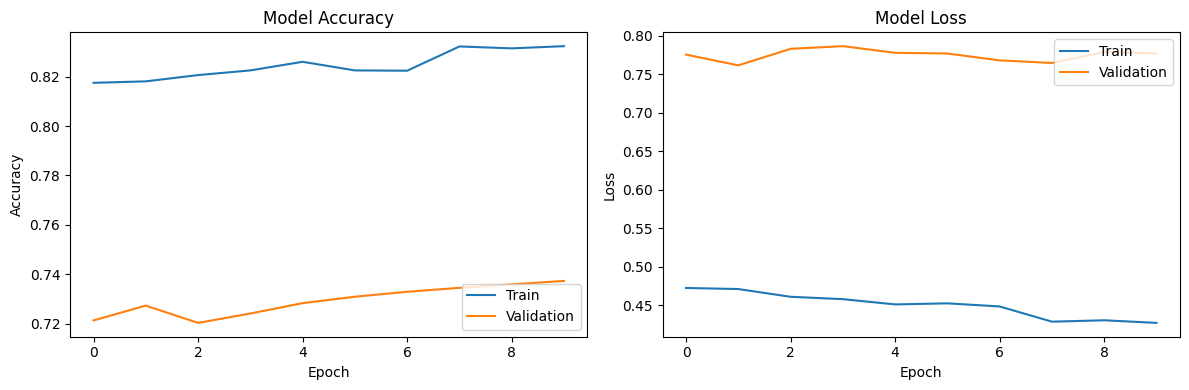

In [42]:
continued_model, continued_history = continue_training('facial_expression_model_4emotions_continued.keras', epochs=10)

In [3]:
# Load the previously trained emotion model and specift the emotion labels as well
model = load_model('C:\\Users\\syedn\\Melodex\\Melodex-Recommendation-System\\venv\\Models\\facial_expression_model_4emotions_continued.keras')
EMOTION_LABELS = ['Angry', 'Fear', 'Happy', 'Sad']

In [5]:


def predictWithWebcam():
    # initialise the haarcascade face detector from cv2
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Capture photo from webcam
    cap = cv2.VideoCapture(0)
    while True:
        ret, frame = cap.read()
        cv2.imshow('Webcam - Press Space Key to capture', frame)
        if cv2.waitKey(1) & 0xFF == ord(' '):  # Space key to capture
            break

    cap.release()
    cv2.destroyAllWindows()

    # Convert it to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect any faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print("No face detected.")
    else:
        # roi for the first face that appears 
        x, y, w, h = faces[0]
        face_roi = gray[y:y + h, x:x + w]
        face_roi = cv2.resize(face_roi, (48, 48))
        face_roi = face_roi / 255.0
        face_roi = np.expand_dims(face_roi, axis=0)
        face_roi = np.expand_dims(face_roi, axis=-1)

        # predict emotion
        prediction = model.predict(face_roi)[0]
        detected_index = np.argmax(prediction)
        detected_emotion = EMOTION_LABELS[detected_index]
        confidence = prediction[detected_index] * 100

        # draw a rectangle and label
        annotated_img = frame.copy()
        cv2.rectangle(annotated_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(annotated_img, f'{detected_emotion} ({confidence:.1f}%)', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
        annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

        plt.imshow(annotated_img_rgb)
        plt.axis('off')
        plt.title(f"Detected Emotion: {detected_emotion} ({confidence:.1f}%)")
        plt.show()
        print(f"Predicted Emotion: {detected_emotion}")
        print(f"Confidence: {confidence:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


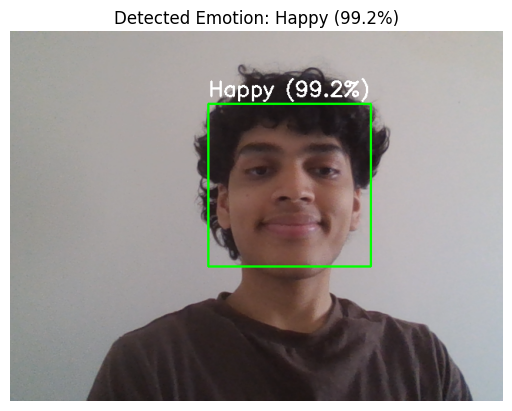

Predicted Emotion: Happy
Confidence: 99.20%


In [13]:
predictWithWebcam()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


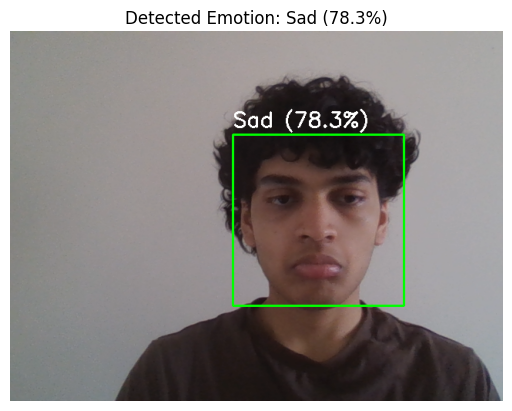

Predicted Emotion: Sad
Confidence: 78.33%


In [15]:
predictWithWebcam()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


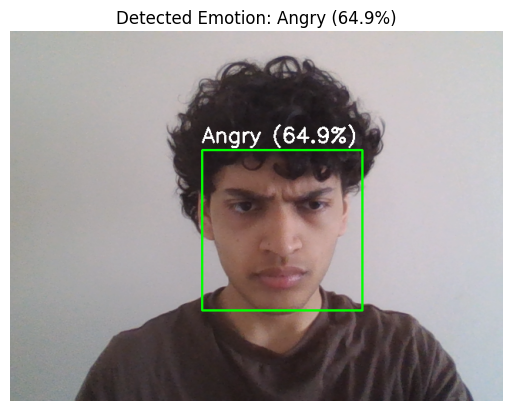

Predicted Emotion: Angry
Confidence: 64.92%


In [16]:
predictWithWebcam()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


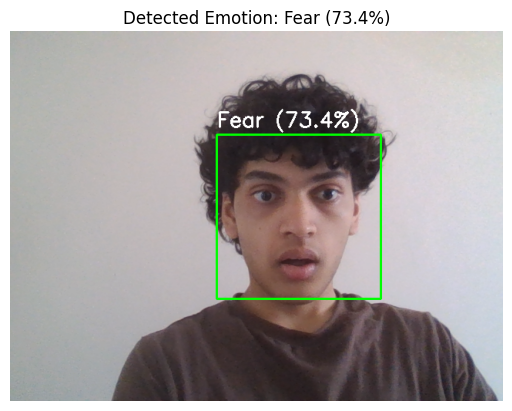

Predicted Emotion: Fear
Confidence: 73.42%


In [17]:
predictWithWebcam()

Found 5002 images belonging to 4 classes.


c:\Users\syedn\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 29s 360ms/step

Classification Report:

              precision    recall  f1-score   support

       angry       0.65      0.62      0.63       957
        fear       0.70      0.50      0.58      1024
       happy       0.90      0.93      0.91      1774
         sad       0.62      0.75      0.68      1247

    accuracy                           0.74      5002
   macro avg       0.72      0.70      0.70      5002
weighted avg       0.74      0.74      0.73      5002



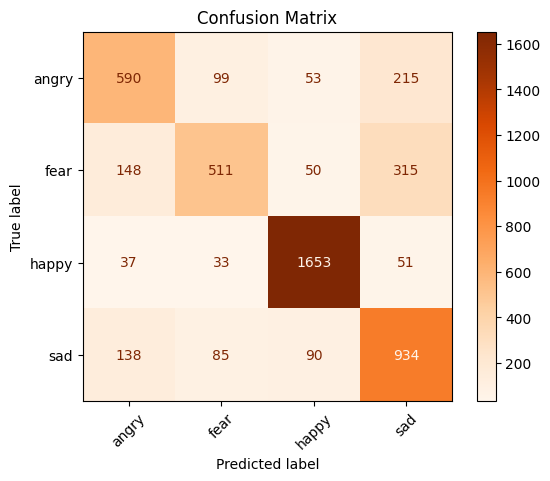

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_data_path,
        target_size=(48, 48),
        color_mode='grayscale',
        batch_size=64,
        classes=allowed_emotions,  
        class_mode='categorical',
        shuffle=False
    )

predictions = model.predict(test_generator)
y_predicted = np.argmax(predictions, axis=1)
y_actual = test_generator.classes
class_labels = list(test_generator.class_indices.keys())


print("\nClassification Report:\n")
print(classification_report(y_actual, y_predicted, target_names=class_labels))

cm = confusion_matrix(y_actual, y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.show()